<a href="https://colab.research.google.com/github/angeruzzi/CompeticoesML/blob/main/4a_Flai_202106_3o_lugar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IV Competição Flai de Machine Learning
Modelo que obteve o 3º Lugar da Competição
---------------------------------
Autor: [Alessandro S. Angeruzzi](https://www.linkedin.com/in/alessandroangeruzzi/)

---------------------------------

Na IV Competição da Comunidade Flai, que ocorreu entre os dias 25/06/2021 e 25/07/2021 e contou com a participação das turmas de 1 a 4, o desafio proposto foi predizer a classificação de clientes de uma empresa de Telecom baseado em dados do histórico de contratos e produtos desses clientes.
Cada participante possuia um limite de 5 submissões dos dados de teste de predição e recebia uma pontuação de acordo com o F1-Score obtido.
Com o modelo abaixo consegui ficar entre as 3 melhores classificações no final.


#Bibliotecas

In [55]:
#Bibliotecas Base
import pandas as pd
import numpy as np

#Pre
import missingno as missing
import matplotlib.pyplot as plt
import seaborn as sns

#Modelos
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

#Tunagem
from sklearn.model_selection import GridSearchCV

#Validação
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score

#Dados

In [56]:
#Base de Dados
fonte_treino = 'https://raw.githubusercontent.com/angeruzzi/Datasource/main/DesafioDDS202106_treino.csv'

orig   = pd.read_csv(fonte_treino) 

treino = orig
treino['Cliente']  = treino['Cliente'].map({'Premium':1, 'Normal':0})

treinoX = treino.drop(['Cliente'], axis = 1) 
treinoy = treino['Cliente']

#Análise

In [57]:
#Lista de Campos e Tipos
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            2500 non-null   object
 1   SeniorCitizen     2500 non-null   int64 
 2   Partner           2500 non-null   object
 3   Dependents        2500 non-null   object
 4   tenure            2500 non-null   int64 
 5   PhoneService      2500 non-null   object
 6   MultipleLines     2500 non-null   object
 7   InternetService   2500 non-null   object
 8   OnlineSecurity    2500 non-null   object
 9   OnlineBackup      2500 non-null   object
 10  DeviceProtection  2500 non-null   object
 11  TechSupport       2500 non-null   object
 12  StreamingTV       2500 non-null   object
 13  StreamingMovies   2500 non-null   object
 14  Contract          2500 non-null   object
 15  PaperlessBilling  2500 non-null   object
 16  PaymentMethod     2500 non-null   object
 17  Cliente       

In [58]:
#Exemplo de Registros
orig.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Cliente
0,Female,0,No,No,20,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1,Female,0,Yes,Yes,59,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,No,Mailed check,1
2,Female,0,Yes,Yes,68,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),1
3,Female,0,No,Yes,35,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,1
4,Male,1,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,0


In [59]:
orig.describe()

,SeniorCitizen,tenure,Cliente
count,2500.000000,2500.000000,2500.000000
mean,0.155200,32.240800,0.470800
std,0.362168,24.474771,0.499246
min,0.000000,1.000000,0.000000
25%,0.000000,9.000000,0.000000
50%,0.000000,29.000000,0.000000
75%,0.000000,55.000000,1.000000
max,1.000000,72.000000,1.000000


In [60]:
#Verificando os valores possiveis dos campos 
#orig.Partner.unique()
#orig.Dependents.unique()
#orig.SeniorCitizen.unique()
#orig.PhoneService.unique()
#orig.PaperlessBilling.unique()
#orig.MultipleLines.unique()
#orig.InternetService.unique()
#orig.OnlineSecurity.unique()
#orig.OnlineBackup.unique()
#orig.DeviceProtection.unique()
#orig.TechSupport.unique()
#orig.StreamingTV.unique()
#orig.StreamingMovies.unique()
#orig.Contract.unique()
#orig.tenure.unique()
orig.PaymentMethod.unique()

array(['Mailed check', 'Credit card (automatic)', 'Electronic check',
       'Bank transfer (automatic)'], dtype=object)

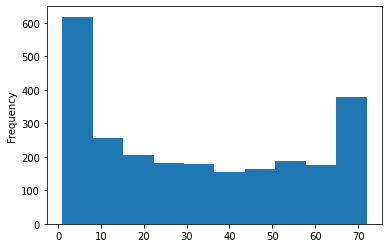

In [61]:
#Distribuição dos valores de 'Tenure' (vairável contínua)
orig['tenure'].plot(kind = 'hist')

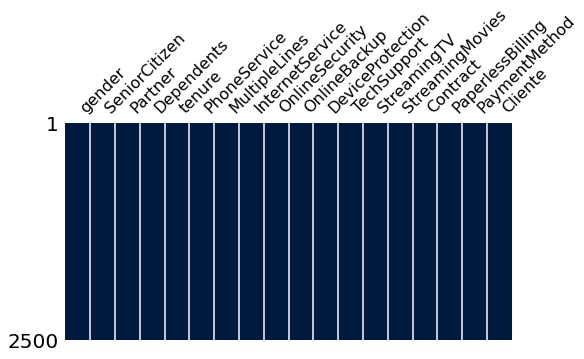

In [62]:
#Verificação de Dados Faltantes
missing.matrix(orig, figsize = (8, 4), color = (0, 0.1, 0.25), sparkline = False);

In [63]:
orig.isnull().sum()*100/orig.shape[0]

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
Cliente             0.0
dtype: float64

#SELEÇÃO DE VARIÁVEIS

In [64]:
origX = orig.drop(['Cliente'], axis = 1) 
origy = orig['Cliente']

#Tratamento de Variáveis para o teste
origX['gender']           = origX['gender'].map({'Female':0, 'Male':1})
origX['Partner']          = origX['Partner'].map({'Yes':1, 'No':0})
origX['Dependents']       = origX['Dependents'].map({'Yes':1, 'No':0})
origX['PaperlessBilling'] = origX['PaperlessBilling'].map({'Yes':1, 'No':0})
origX['PhoneService']     = origX['PhoneService'].map({'Yes':1, 'No':0})
origX['MultipleLines']    = origX['MultipleLines'].map({'Yes':1, 'No':0, 'No phone service':0})
origX['OnlineSecurity']   = origX['OnlineSecurity'].map({'Yes':1, 'No':0, 'No internet service':0})
origX['OnlineBackup']     = origX['OnlineBackup'].map({'Yes':1, 'No':0, 'No internet service':0})
origX['DeviceProtection'] = origX['DeviceProtection'].map({'Yes':1, 'No':0, 'No internet service':0})
origX['TechSupport']      = origX['TechSupport'].map({'Yes':1, 'No':0, 'No internet service':0})
origX['StreamingTV']      = origX['StreamingTV'].map({'Yes':1, 'No':0, 'No internet service':0})
origX['StreamingMovies']  = origX['StreamingMovies'].map({'Yes':1, 'No':0, 'No internet service':0})
variaveis_toDummie        = ['InternetService', 'Contract',  'PaymentMethod']
origX = pd.get_dummies(origX, columns = variaveis_toDummie, drop_first = True)

#origX.head()

modelo_base = RandomForestClassifier(max_depth = 3) 
modelo_base.fit(origX, origy)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

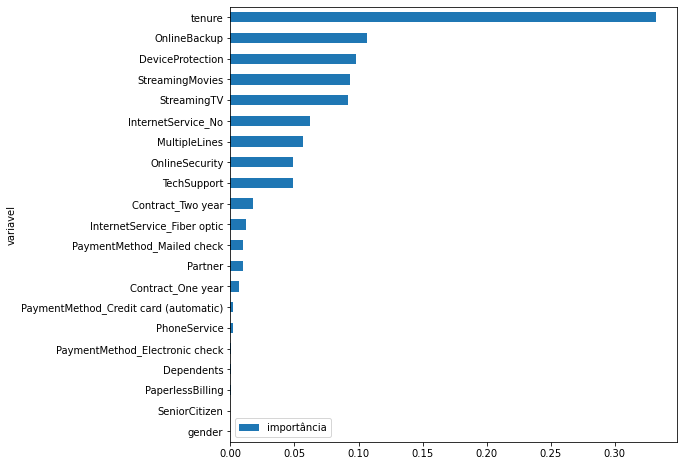

In [65]:
variaveis = pd.DataFrame()
variaveis['variavel'] = origX.columns
variaveis['importância'] = modelo_base.feature_importances_
variaveis.sort_values(by = 'importância', ascending = True, inplace = True)
variaveis.set_index('variavel', inplace = True)
variaveis.plot(kind='barh', figsize=(8, 8));

In [66]:
  origX.drop(['PaperlessBilling'], axis = 1, inplace = True) 
  origX.drop(['Dependents'], axis = 1, inplace = True)
  origX.drop(['SeniorCitizen'], axis = 1, inplace = True)
  origX.drop(['gender'], axis = 1, inplace = True) 

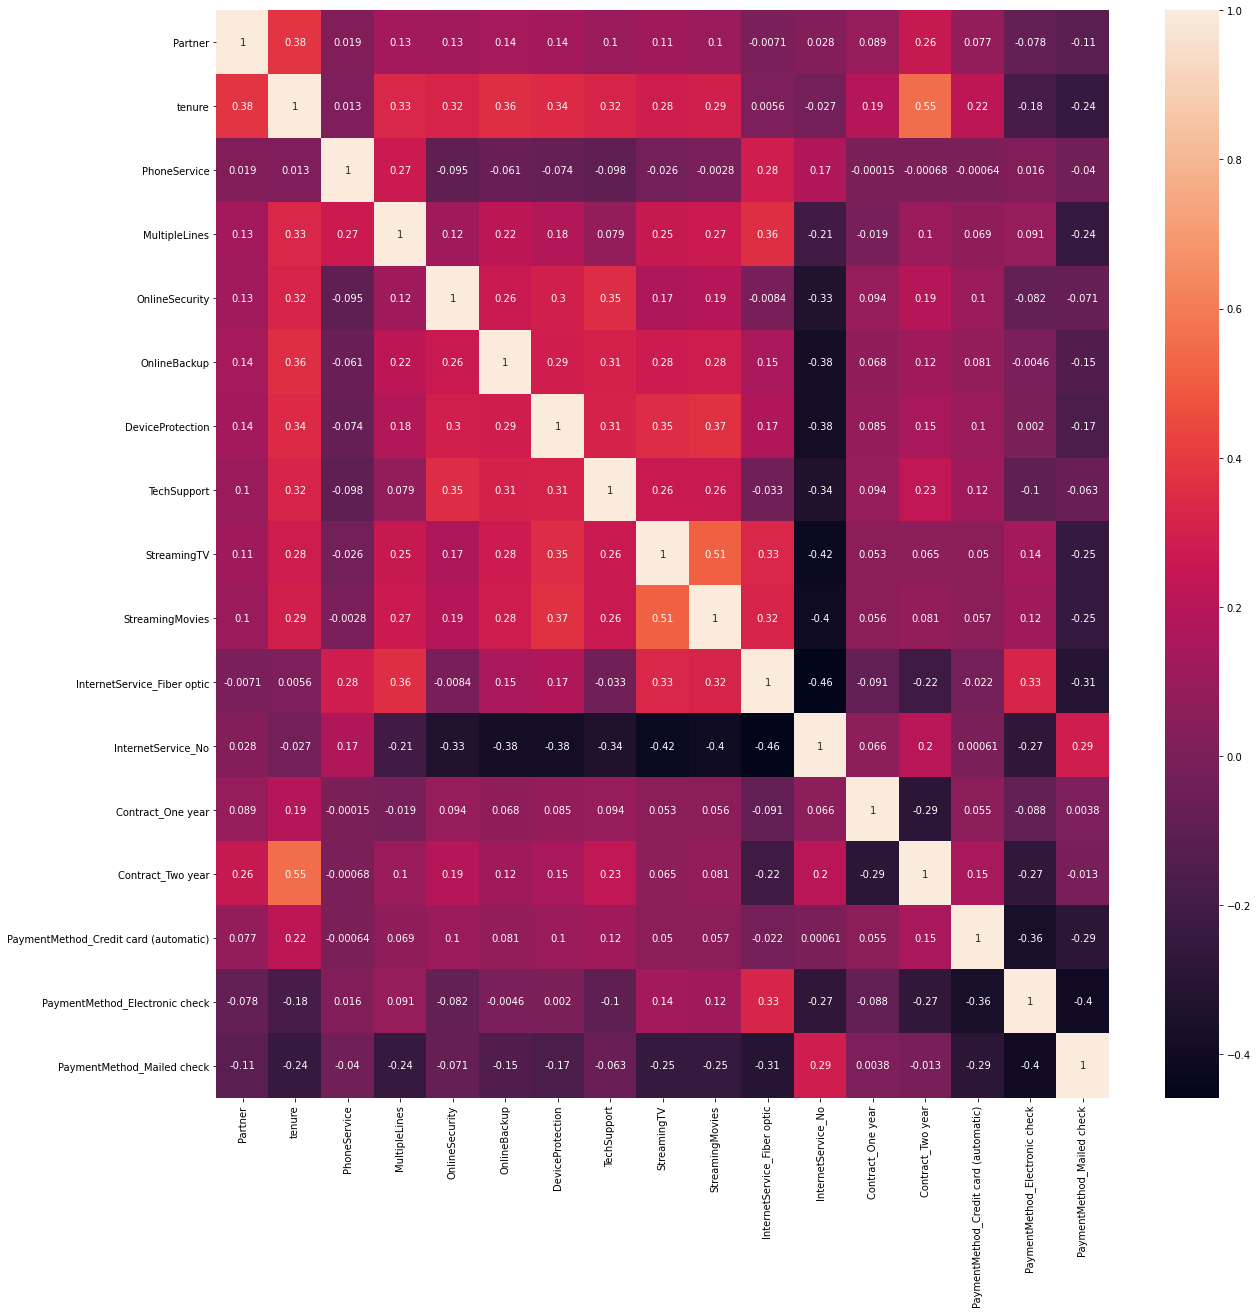

In [67]:
#Verificando se há correlação entre as variáveis selecionadas
plt.figure(figsize = [20,20])
sns.heatmap(origX.corr(),annot = True)

#TRANSFORMAÇÃO

In [68]:
def Transf(dados):

  #Remoção de campos que não serão utilizados
  dados.drop(['gender'], axis = 1, inplace = True)
  dados.drop(['Dependents'], axis = 1, inplace = True)
  dados.drop(['SeniorCitizen'], axis = 1, inplace = True)
  dados.drop(['PaperlessBilling'], axis = 1, inplace = True)  

  #Transformação de Variáveis Categóricas para numéricas
  dados['Partner']          = dados['Partner'].map({'Yes':1, 'No':0})
  dados['PhoneService']     = dados['PhoneService'].map({'Yes':1, 'No':0})

  dados['MultipleLines']    = dados['MultipleLines'].map({'Yes':1, 'No':0, 'No phone service':0})
  
  dados['OnlineSecurity']   = dados['OnlineSecurity'].map({'Yes':1, 'No':0, 'No internet service':0})
  dados['OnlineBackup']     = dados['OnlineBackup'].map({'Yes':1, 'No':0, 'No internet service':0})
  dados['DeviceProtection'] = dados['DeviceProtection'].map({'Yes':1, 'No':0, 'No internet service':0})
  dados['TechSupport']      = dados['TechSupport'].map({'Yes':1, 'No':0, 'No internet service':0})
  dados['StreamingTV']      = dados['StreamingTV'].map({'Yes':1, 'No':0, 'No internet service':0})
  dados['StreamingMovies']  = dados['StreamingMovies'].map({'Yes':1, 'No':0, 'No internet service':0})

  #Normalização
  dados['tenure']           = dados['tenure']/100
  
  ##Dummyficação
  variaveis_toDummie        = ['Contract', 'InternetService', 'PaymentMethod']
  dados = pd.get_dummies(dados, columns = variaveis_toDummie, drop_first = True)

  return dados 

In [69]:
treinoX = Transf(treinoX)

#Hipertunagem

Após testes com diversos modelos o que apresentou melhores resultados foi o GradientBoostingClassifier;
então a hipertunagem e testes de modelos abaixo está sendo realizado apenas com este modelo

In [72]:
def Tunagem(modelo, treino, targets, parametros, validacao, score):    
    search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = score, cv = validacao, 
                                  verbose = 1, n_jobs = -1)
    search.fit(treino, targets) 
    bestModel = search.best_estimator_
    bestScore = search.best_score_
    bestParam = search.best_params_

    return {
            'bestModel': bestModel,
            'bestScore': bestScore,
            'bestParam': bestParam
    }

In [70]:
validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 20)
#validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)

testeTunModels = [GradientBoostingClassifier()]
testeTunParams = [
                  {
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 3, 5],
                   'max_depth' : [2, 4, 6],
                   'n_estimators': [50, 100, 150],
                   'learning_rate': np.arange(0.1, 1.1, 0.1)
                  }
]

In [ ]:
for i in range(len(testeTunModels)):
  ret = Tunagem(testeTunModels[i], treinoX, treinoy, testeTunParams[i], validacao, 'f1')
  print(ret)

#Validação de Modelos

In [ ]:
def CompareML(X, y, lista_de_modelos, nome_dos_modelos, validacao):
  lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
  nome_das_medidas = ['acurácia', 'sensibilidade', 'precisão', 'eficiência', 'f1-score']
  resultados0 = {}
  
  for i in range(len(lista_de_modelos)):
      print('Rodando modelo: ' + nome_dos_modelos[i])
      accs_vc = cross_validate(lista_de_modelos[i], X, y, cv = validacao, scoring = lista_de_medidas)

      acc = accs_vc['test_accuracy'].mean()
      sen = accs_vc['test_recall'].mean()
      vpp = accs_vc['test_precision'].mean()
      bac = accs_vc['test_balanced_accuracy'].mean()
      f1s = accs_vc['test_f1'].mean()

      resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, f1s, bac]
      
  resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T
  return resultados

In [ ]:
validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 20)

#Comparação de modelos GBC
mod_gbc     = GradientBoostingClassifier()
mod_gbc50A  = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=50)
mod_gbc50B  = GradientBoostingClassifier(learning_rate=0.4, max_depth=2, n_estimators=50)
mod_gbc100A = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=100, min_samples_leaf=1, min_samples_split=2)
mod_gbc100B = GradientBoostingClassifier(learning_rate=0.4, max_depth=2, n_estimators=100)
mod_gbc200  = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, min_samples_leaf=1, min_samples_split=2)

In [ ]:
lista_de_modelos = [
                      mod_gbc     ,                    
                      mod_gbc50A  ,                    
                      mod_gbc50B  ,
                      mod_gbc100A ,
                      mod_gbc100B ,
                      mod_gbc200  
                    ]

nome_dos_modelos = [
                        'GBC',
                        'GBC-50-A' ,
                        'GBC-50-B' ,                    
                        'GBC-100-A',
                        'GBC-100-B',
                        'GBC-200'  
                    ]

In [ ]:
resultados = CompareML(treinoX, treinoy, lista_de_modelos, nome_dos_modelos, validacao)
resultados.sort_values(by = 'f1-score', ascending = False)

Rodando modelo: GBC
Rodando modelo: GBC-50-A
Rodando modelo: GBC-50-B
Rodando modelo: GBC-100-A
Rodando modelo: GBC-100-B
Rodando modelo: GBC-200


,acurácia,sensibilidade,precisão,eficiência,f1-score
GBC-100-A,0.98704,0.985941,0.986642,0.986229,0.986983
GBC-50-B,0.98662,0.985642,0.986039,0.985786,0.986564
GBC-100-B,0.98656,0.985094,0.986456,0.985711,0.986481
GBC-200,0.98600,0.984111,0.986244,0.985111,0.985895
GBC,0.98484,0.984326,0.983657,0.983911,0.984811
GBC-50-A,0.98408,0.984366,0.982022,0.983116,0.984097


In [ ]:
dadosSelecionados = treinoX

In [ ]:
modelo_decidido = mod_gbc100A
modelo_decidido.fit(dadosSelecionados,treinoy)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#preditos Treino
preditos = modelo_decidido.predict(dadosSelecionados)
f1 = f1_score(treinoy, preditos)
f1

0.9949066213921902

#ARQUIVO SUBMISSÃO

In [ ]:
fonte_saida  = 'https://raw.githubusercontent.com/angeruzzi/Datasource/main/DesafioDDS202106_teste.csv'
saida  = pd.read_csv(fonte_saida)

saida = Transf(saida)

pred = modelo_decidido.predict(saida)

subm = pd.DataFrame()
subm['Cliente'] = pred
subm.to_csv('submissao5.csv', index = False)

In [ ]:
from google.colab import files
files.download("submissao5.csv")